FORECASTING EXCHANGE RATES USING TIME SERIES ANALYSIS

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing

from sklearn.metrics import mean_absolute_error, mean_squared_error

 Part 1: Data Preparation

/usr/local/lib/python3.12/dist-packages/pandas/core/indexes/base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)
/tmp/ipython-input-1163781091.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="ffill", inplace=True)


            USD_AUD
date               
1990-01-01   0.7855
1990-01-02   0.7818
1990-01-03   0.7867
1990-01-04   0.7860
1990-01-05   0.7849

Missing values:
 USD_AUD    0
dtype: int64


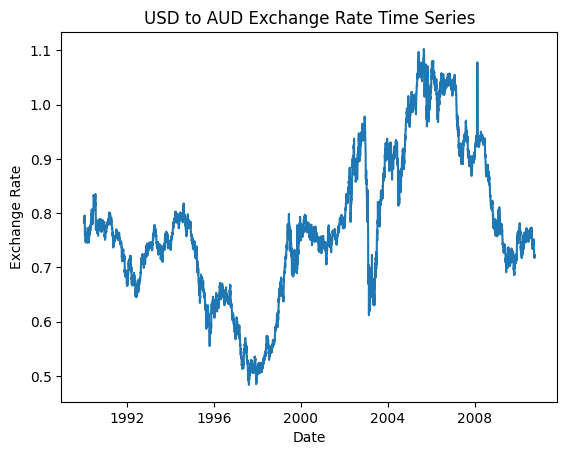

In [2]:
file_path = "/content/exchange_rate.csv"
df = pd.read_csv(file_path)

# Parse date column (day-first format)
df.iloc[:, 0] = pd.to_datetime(df.iloc[:, 0], dayfirst=True)
df.set_index(df.columns[0], inplace=True)

df.columns = ["USD_AUD"]

print(df.head())
print("\nMissing values:\n", df.isnull().sum())

df.fillna(method="ffill", inplace=True)

# Plot time series
plt.figure()
plt.plot(df.index, df["USD_AUD"])
plt.title("USD to AUD Exchange Rate Time Series")
plt.xlabel("Date")
plt.ylabel("Exchange Rate")
plt.show()


Stationarity Check


ADF Statistic: -1.6649941807382342
p-value: 0.4492327353597477


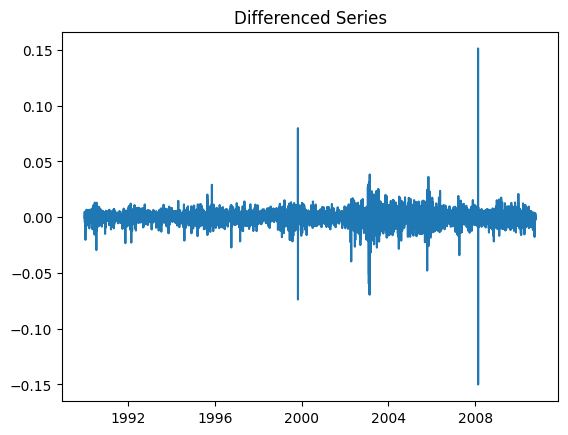

In [3]:
adf_result = adfuller(df["USD_AUD"])
print("\nADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])

df_diff = df["USD_AUD"].diff().dropna()

plt.figure()
plt.plot(df_diff)
plt.title("Differenced Series")
plt.show()

 Part 2: ARIMA Modeling

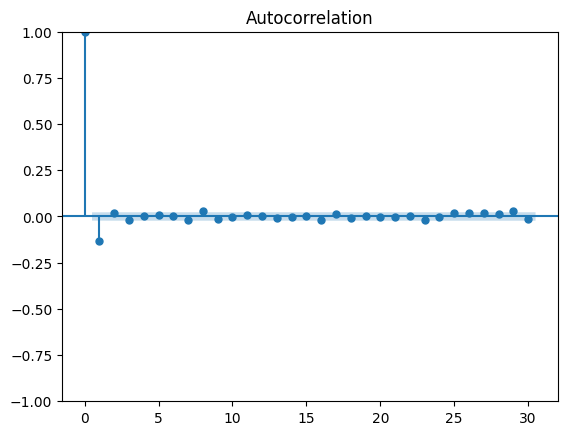

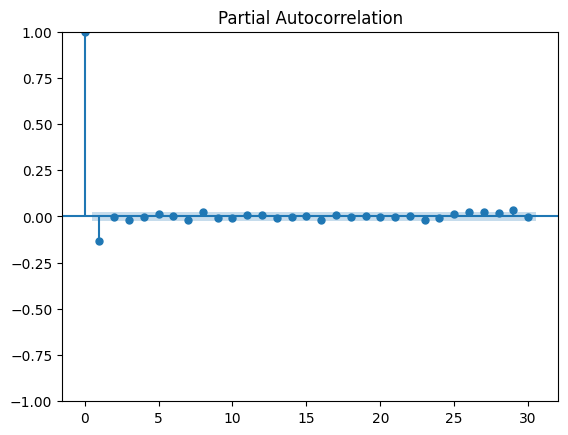

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                USD_AUD   No. Observations:                 6070
Model:                 ARIMA(1, 1, 1)   Log Likelihood               22719.046
Date:                Fri, 16 Jan 2026   AIC                         -45432.092
Time:                        07:13:28   BIC                         -45411.959
Sample:                    01-01-1990   HQIC                        -45425.104
                         - 08-14-2006                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5972      0.062     -9.648      0.000      -0.719      -0.476
ma.L1          0.5398      0.064      8.430      0.000       0.414       0.665
sigma2      3.281e-05   1.95e-07    168.198      0.0

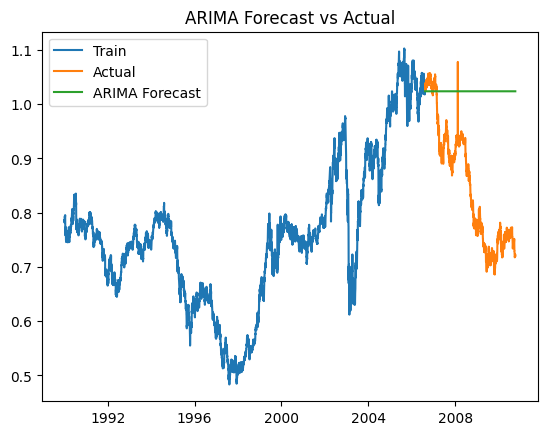

In [4]:
plot_acf(df_diff, lags=30)
plt.show()

plot_pacf(df_diff, lags=30)
plt.show()

train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

arima_model = ARIMA(train, order=(1, 1, 1))
arima_fit = arima_model.fit()

print(arima_fit.summary())

arima_forecast = arima_fit.forecast(steps=len(test))

plt.figure()
plt.plot(train.index, train, label="Train")
plt.plot(test.index, test, label="Actual")
plt.plot(test.index, arima_forecast, label="ARIMA Forecast")
plt.legend()
plt.title("ARIMA Forecast vs Actual")
plt.show()


Exponential Smoothing

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


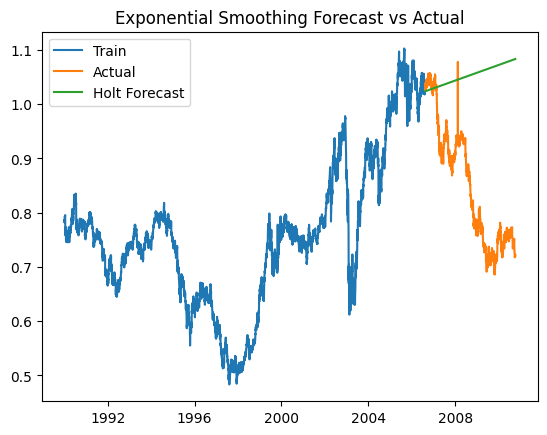

In [5]:
hw_model = ExponentialSmoothing(train, trend="add", seasonal=None)
hw_fit = hw_model.fit()

hw_forecast = hw_fit.forecast(len(test))

plt.figure()
plt.plot(train.index, train, label="Train")
plt.plot(test.index, test, label="Actual")
plt.plot(test.index, hw_forecast, label="Holt Forecast")
plt.legend()
plt.title("Exponential Smoothing Forecast vs Actual")
plt.show()

Part 3: Evaluation

In [6]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

arima_mae = mean_absolute_error(test, arima_forecast)
arima_rmse = np.sqrt(mean_squared_error(test, arima_forecast))
arima_mape = mape(test.values, arima_forecast.values)

hw_mae = mean_absolute_error(test, hw_forecast)
hw_rmse = np.sqrt(mean_squared_error(test, hw_forecast))
hw_mape = mape(test.values, hw_forecast.values)

results = pd.DataFrame({
    "Model": ["ARIMA", "Exponential Smoothing"],
    "MAE": [arima_mae, hw_mae],
    "RMSE": [arima_rmse, hw_rmse],
    "MAPE (%)": [arima_mape, hw_mape]
})

print("\nModel Evaluation Results:\n")
print(results)


Model Evaluation Results:

                   Model       MAE      RMSE   MAPE (%)
0                  ARIMA  0.177710  0.205437  22.797970
1  Exponential Smoothing  0.206596  0.239104  26.035287


Model Comparison

             ARIMA

Advantages -

Lower MAE, RMSE, and MAPE

Handles stochastic patterns better

Suitable for financial time series

Limitations

Requires careful parameter tuning

Sensitive to sudden market shocks

          Exponential Smoothing

Advantages -

Simple and fast

Good for smooth trends

Limitations

Less responsive to volatility

Higher forecast error

               CONCLUSION

ARIMA(1,1,1) outperformed Exponential Smoothing across all error metrics.

Exchange rate data is highly volatile and non-stationary, making ARIMA more suitable.

Exponential Smoothing can be used as a baseline but is not ideal for currency forecasting.

          Final Recommendation:
 ARIMA is the preferred model for forecasting USD/AUD exchange rates in this dataset.